In [ ]:
import pandas as pd
df=pd.read_csv('/content/imdb_dataset.csv')
df.head()

,text,label,type
0,Story of a man who has unnatural feelings for ...,0,train
1,Airport '77 starts as a brand new luxury 747 p...,0,train
2,This film lacked something I couldn't put my f...,0,train
3,"Sorry everyone,,, I know this is supposed to b...",0,train
4,When I was little my parents took me along to ...,0,train


In [ ]:
import re
import html
import unicodedata

def clean_text_bert(text):
    text = html.unescape(str(text))
    text = re.sub(r'<.*?>', ' ', text)
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'([,.!?])\1+', r'\1', text)  # thu gọn dấu câu lặp
    text = text.lower()  # nếu bạn dùng bert-base-uncased
    return text


In [ ]:
bert_data = df['text'].apply(clean_text_bert)

In [ ]:
print(bert_data)

0        story of a man who has unnatural feelings for ...
1        airport '77 starts as a brand new luxury 747 p...
2        this film lacked something i couldn't put my f...
3        sorry everyone, i know this is supposed to be ...
4        when i was little my parents took me along to ...
                               ...                        
49995    i was extraordinarily impressed by this film. ...
49996    although i'm not a golf fan, i attended a snea...
49997    from the start of "the edge of love", the view...
49998    this movie, with all its complexity and subtle...
49999    i've seen this story before but my kids haven'...
Name: text, Length: 50000, dtype: object


In [ ]:
bert_df = pd.DataFrame({
    'text': bert_data,
    'label': df['label']
})


In [ ]:
bert_df.head()

,text,label
0,story of a man who has unnatural feelings for ...,0
1,airport '77 starts as a brand new luxury 747 p...,0
2,this film lacked something i couldn't put my f...,0
3,"sorry everyone, i know this is supposed to be ...",0
4,when i was little my parents took me along to ...,0


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers scikit-learn tqdm


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:

from sklearn.model_selection import StratifiedKFold
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch
import numpy as np
from tqdm import tqdm
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(bert_df['text'], bert_df['label'])):
    print(f"\n===== Fold {fold+1} =====")

    X_train, X_val = bert_df['text'].iloc[train_idx], bert_df['text'].iloc[val_idx]
    y_train, y_val = bert_df['label'].iloc[train_idx], bert_df['label'].iloc[val_idx]

    # 3Tokenize
    train_enc = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
    val_enc   = tokenizer(list(X_val), truncation=True, padding=True, max_length=128, return_tensors='pt')

    # 4 Dataset & DataLoader
    train_dataset = torch.utils.data.TensorDataset(
        train_enc['input_ids'], train_enc['attention_mask'], torch.tensor(y_train.values)
    )
    val_dataset = torch.utils.data.TensorDataset(
        val_enc['input_ids'], val_enc['attention_mask'], torch.tensor(y_val.values)
    )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

    # 5️Model + Optimizer
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_loader) * 3
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    # 6️ Huấn luyện
    for epoch in range(3):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            b_input_ids, b_mask, b_labels = [t.to(device) for t in batch]
            optimizer.zero_grad()

            outputs = model(input_ids=b_input_ids, attention_mask=b_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

    # 7️ Đánh giá
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            b_input_ids, b_mask, b_labels = [t.to(device) for t in batch]
            outputs = model(input_ids=b_input_ids, attention_mask=b_mask)
            logits = outputs.logits#ma trận xác suất trước softmax
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())#danh sách nhãn mô hình dự đoán
            true_labels.extend(b_labels.cpu().numpy())# danh sách nhãn mô hình thực tế

    acc = np.mean(np.array(preds) == np.array(true_labels))# So sánh từng dự đoán với nhãn thật
    print(f" Fold {fold+1} Accuracy: {acc:.4f}")
    accuracies.append(acc)
print("\n Accuracy từng fold:", accuracies)
print(" Accuracy trung bình:", np.mean(accuracies))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]


===== Fold 1 =====


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 2500/2500 [07:30<00:00,  5.55it/s]


Epoch 1 | Loss: 0.3230


Epoch 2: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 2 | Loss: 0.1947


Epoch 3: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 3 | Loss: 0.1089
 Fold 1 Accuracy: 0.8977

===== Fold 2 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 2500/2500 [07:34<00:00,  5.50it/s]


Epoch 1 | Loss: 0.3216


Epoch 2: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 2 | Loss: 0.1921


Epoch 3: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 3 | Loss: 0.1034
 Fold 2 Accuracy: 0.8882

===== Fold 3 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 2500/2500 [07:34<00:00,  5.49it/s]


Epoch 1 | Loss: 0.3247


Epoch 2: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 2 | Loss: 0.1936


Epoch 3: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 3 | Loss: 0.1075
 Fold 3 Accuracy: 0.8888

===== Fold 4 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 2500/2500 [07:34<00:00,  5.50it/s]


Epoch 1 | Loss: 0.3196


Epoch 2: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 2 | Loss: 0.1946


Epoch 3: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 3 | Loss: 0.1050
 Fold 4 Accuracy: 0.8981

===== Fold 5 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 2500/2500 [07:34<00:00,  5.50it/s]


Epoch 1 | Loss: 0.3181


Epoch 2: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 2 | Loss: 0.1899


Epoch 3: 100%|██████████| 2500/2500 [07:35<00:00,  5.49it/s]


Epoch 3 | Loss: 0.1020
 Fold 5 Accuracy: 0.8945

 Accuracy từng fold: [np.float64(0.8977), np.float64(0.8882), np.float64(0.8888), np.float64(0.8981), np.float64(0.8945)]
 Accuracy trung bình: 0.8934599999999999


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
'''save_path = "/content/drive/MyDrive/bert_sentiment_model"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(" Model đã được lưu vào Google Drive:", save_path)'''


'save_path = "/content/drive/MyDrive/bert_sentiment_model"\nmodel.save_pretrained(save_path)\ntokenizer.save_pretrained(save_path)\nprint(" Model đã được lưu vào Google Drive:", save_path)'

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

load_path = "/content/drive/MyDrive/bert_sentiment_model"
model = DistilBertForSequenceClassification.from_pretrained(load_path)
tokenizer = DistilBertTokenizer.from_pretrained(load_path)
model.config.id2label = {0: "Negative", 1: "Positive"}
model.config.label2id = {"Negative": 0, "Positive": 1}

print(" Model đã load lại thành công!")


 Model đã load lại thành công!


# test

In [ ]:
movie_test_sentences = [
    # Original 25
    "The movie had its moments, but it didn’t fully grab me.",
    "I liked the idea, though the execution felt off.",
    "Some parts were brilliant, others just confusing.",
    "The performances were fine, though the pacing was uneven.",
    "It wasn’t bad, just not something I’d watch again.",
    "The story started strong but lost energy halfway.",
    "I wasn’t bored, but I also wasn’t impressed.",
    "There were flashes of genius hidden behind clumsy writing.",
    "It looked great visually, but the plot didn’t match the tone.",
    "I expected more, though it wasn’t a complete letdown.",
    "The movie lingered in my mind, though I’m not sure why.",
    "It had a strange charm that made it hard to dislike.",
    "The humor didn’t always land, but the cast seemed genuine.",
    "I can’t tell if I liked it or just wanted to like it.",
    "The emotional scenes worked, even if the logic didn’t.",
    "It’s one of those films that’s better the second time around.",
    "A bit pretentious, but the direction was solid.",
    "It felt both too long and not long enough to explain itself.",
    "Some characters were interesting, others felt unnecessary.",
    "The soundtrack was better than the film itself.",
    "I didn’t love it, but it wasn’t a waste either.",
    "It tries to say something deep, though I’m not sure what.",
    "The mix of genres made it unique, if a bit messy.",
    "A film that’s easy to admire but hard to enjoy.",
    "Strangely satisfying, even though it left me confused.",
    "It had a warmth that stayed with me long after it ended.",
    "The storytelling felt genuine and emotionally rich.",
    "A thoughtful film that rewards patient viewers.",
    "It wasn’t flashy, but it was beautifully sincere.",
    "A subtle and touching experience that grows on you."
]

true_labels = [
    # label
    0, 0, 1, 1, 0,
    0, 0, 1, 0, 1,
    1, 1, 1, 0, 1,
    1, 0, 0, 1, 0,
    0, 1, 1, 0, 1,
    1, 1, 1, 1, 1
]


In [ ]:
import torch
import torch.nn.functional as F

def predict_sentiment(text):
    clean = clean_text_bert(text)
    inputs = tokenizer(clean, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)  # lấy xác suất
    pred = torch.argmax(probs, dim=-1).item()
    prob = probs[0][1].item()  # xác suất lớp "Positive"
    return pred, prob

# Lưu cả nhãn dự đoán và xác suất
pred_labels = []
prob_labels = []

for text, y_true in zip(movie_test_sentences, true_labels):
    pred, prob = predict_sentiment(text)  #  Lấy cả nhãn và xác suất
    pred_labels.append(pred)
    prob_labels.append(prob)

    # So sánh đúng/sai
    result = "✅ Đúng" if pred == y_true else "❌ Sai"
    pred_label = "Tích cực 😊" if pred == 1 else "Tiêu cực 😞"
    true_label = "Tích cực" if y_true == 1 else "Tiêu cực"

    print(f"{result} | Dự đoán: {pred_label} | Thật: {true_label} | Xác suất lớp 1 = {prob:.2f}")
    print(f"→ {text}\n")


✅ Đúng | Dự đoán: Tiêu cực 😞 | Thật: Tiêu cực | Xác suất lớp 1 = 0.09
→ The movie had its moments, but it didn’t fully grab me.

✅ Đúng | Dự đoán: Tiêu cực 😞 | Thật: Tiêu cực | Xác suất lớp 1 = 0.09
→ I liked the idea, though the execution felt off.

✅ Đúng | Dự đoán: Tích cực 😊 | Thật: Tích cực | Xác suất lớp 1 = 0.72
→ Some parts were brilliant, others just confusing.

❌ Sai | Dự đoán: Tiêu cực 😞 | Thật: Tích cực | Xác suất lớp 1 = 0.35
→ The performances were fine, though the pacing was uneven.

❌ Sai | Dự đoán: Tích cực 😊 | Thật: Tiêu cực | Xác suất lớp 1 = 0.64
→ It wasn’t bad, just not something I’d watch again.

✅ Đúng | Dự đoán: Tiêu cực 😞 | Thật: Tiêu cực | Xác suất lớp 1 = 0.02
→ The story started strong but lost energy halfway.

✅ Đúng | Dự đoán: Tiêu cực 😞 | Thật: Tiêu cực | Xác suất lớp 1 = 0.19
→ I wasn’t bored, but I also wasn’t impressed.

❌ Sai | Dự đoán: Tiêu cực 😞 | Thật: Tích cực | Xác suất lớp 1 = 0.00
→ There were flashes of genius hidden behind clumsy writing.

✅

In [ ]:
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

# Đánh giá cơ bản
print("Accuracy:", accuracy_score(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels, target_names=["Negative", "Positive"]))

# Ma trận nhầm lẫn
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", cm)

Accuracy: 0.6333333333333333
              precision    recall  f1-score   support

    Negative       0.55      0.50      0.52        12
    Positive       0.68      0.72      0.70        18

    accuracy                           0.63        30
   macro avg       0.61      0.61      0.61        30
weighted avg       0.63      0.63      0.63        30

Confusion Matrix:
 [[ 6  6]
 [ 5 13]]


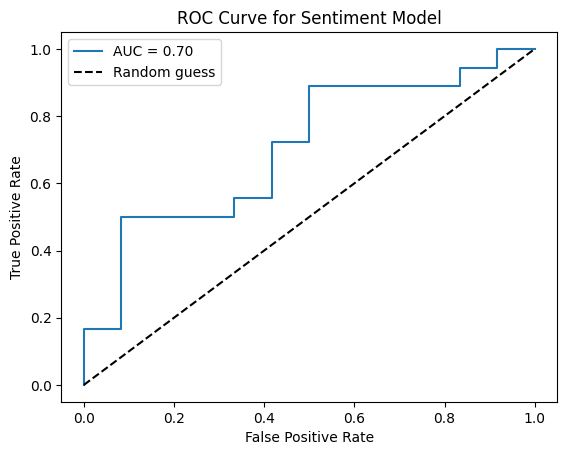

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(true_labels, prob_labels)
auc = roc_auc_score(true_labels, prob_labels)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve for Sentiment Model")
plt.show()
